<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Разности-временного-ряда" data-toc-modified-id="Разности-временного-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Разности временного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Качество-прогноза" data-toc-modified-id="Качество-прогноза-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Качество прогноза</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#Тест-лучшей-модели" data-toc-modified-id="Тест-лучшей-модели-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Тест лучшей модели</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install -U scikit-learn -q

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt


from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    TimeSeriesSplit,
    GridSearchCV
)

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


RANDOM_STATE = 42 
tscv = TimeSeriesSplit(n_splits=5)

In [23]:
df_1 = 'C:/Users/Gpets/Data With Python/taxi.csv'

df_2 = '/datasets/taxi.csv'

def load_data(primary_path, secondary_path):
    if os.path.exists(primary_path):
        try:
            return pd.read_csv(primary_path, sep=',')
        except:
            return pd.read_csv(primary_path, sep=';')
    elif os.path.exists(secondary_path):
        try:
            return pd.read_csv(secondary_path, sep=',')
        except:
            return pd.read_csv(secondary_path, sep=';')
    else:
        print(f"Файл не найден: {primary_path} или {secondary_path}")
        return None


df = load_data(df_1, df_2)

In [24]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Выводим основную информацию о датафрейме с помощью метода `info()`

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


У нас 26496 записей, без пропущенных значений. 

Приведем данные к удобному формату, для их анализа выделим временной промежуток, а затем построим график временного ряда.

In [26]:
df['datetime'] = pd.to_datetime(df['datetime'], errors = 'coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Установим индекс таблицы равным столбцу `datetime`

In [27]:
df = df.set_index('datetime')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Провреим, в хронологическом ли порядке расположены даты и время с помощью атрибута `is_monotonic`. 

Если порядок соблюдён, атрибут вернёт `True`, если нет — `False`.

In [28]:
df.index.is_monotonic

True

Проведем ресемплирование по одному часу.

In [29]:
df = df.resample('1H').sum()

## Анализ

### Скользящее среднее

Снизим колебания, применив скользящее среднее.

Скользящие средние помогают сгладить временной ряд и выделить тренды. Рассчитаем скользящие средние с разными окнами (например, 12 часов и 24 часа):

<AxesSubplot:xlabel='datetime'>

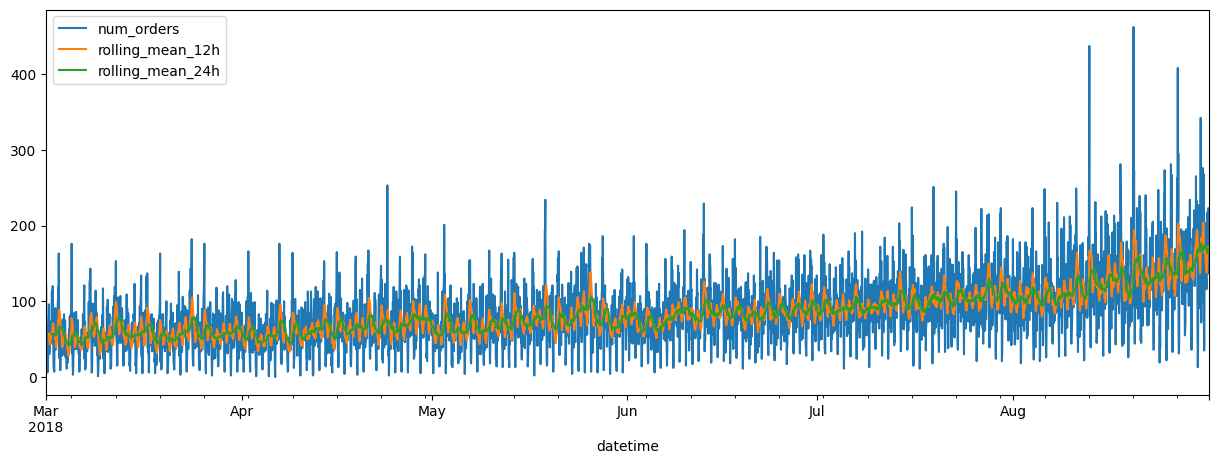

In [30]:
df['rolling_mean_12h'] = df['num_orders'].rolling(12).mean()
df['rolling_mean_24h'] = df['num_orders'].rolling(24).mean()
df.plot(figsize=(15, 5))

Судя по графику с двумя скользящими средними (12 и 24 часа):


* **`Тренды:`**

    * Общий рост: Скользящие средние показывают общий рост числа заказов с марта по август. Это показывает что спрос на такси в аэропортах увеличивается со временем.

    * Долгосрочный тренд: Скользящая средняя с окном 24 часа сглаживает данные сильнее, показывая более плавный долгосрочный тренд по сравнению с 12-часовой средней.
    
    
* **`Сезонность:`**

    * Краткосрочные колебания: На исходных данных видны регулярные пики и спады, которые, скорее всего, связаны с суточной сезонностью (разные периоды активности в течение дня).

    * Колебания вокруг средней: Обе скользящие средние (12 и 24 часа) сглаживают суточные колебания, но пики всё ещё заметны, особенно в диапазоне менее 12 часов.

In [31]:
df = df.drop(['rolling_mean_12h'], axis = 1)

### Тренды и сезонность

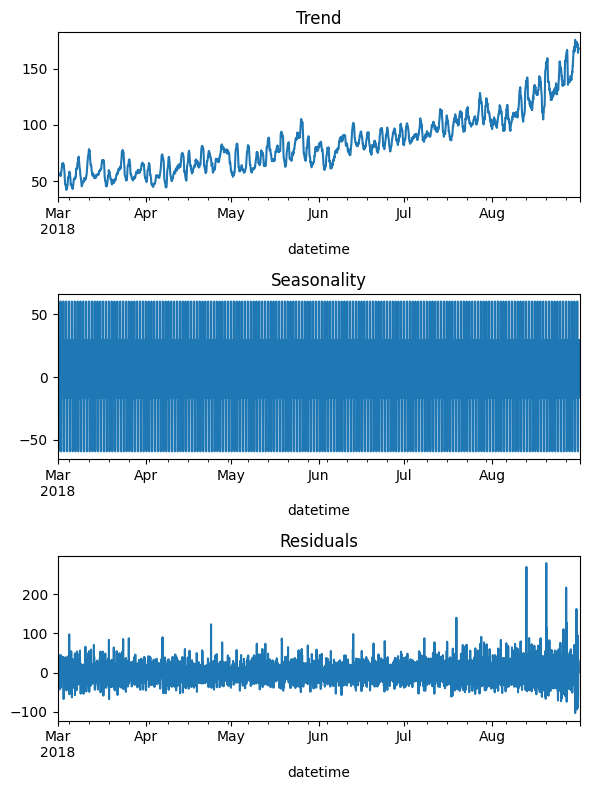

In [32]:
decomposed = seasonal_decompose(df['num_orders'])


plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)


decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На графике представлены три компоненты временного ряда: тренд, сезонность и остатки. Вот что можно отметить:


* Тренд:

    * Наблюдается стабильный рост числа заказов с марта по август.


* Сезонность: 

    * Сезонный компонент показывает регулярные циклы, которые повторяются примерно каждые 24 часа. Это может быть связано с суточными пиками активности. Амплитуда сезонности остаётся относительно постоянной на протяжении всего периода.
  
  
  
* Остатки: 

    * Остатки выглядят шумно, но с увеличением значения тренда их амплитуда также возрастает.

### Разности временного ряда

Прогнозировать данные помогут нам стационарные ряды. Чтобы ряд сделать стационарным, найдём разности его значений.

<AxesSubplot:xlabel='datetime'>

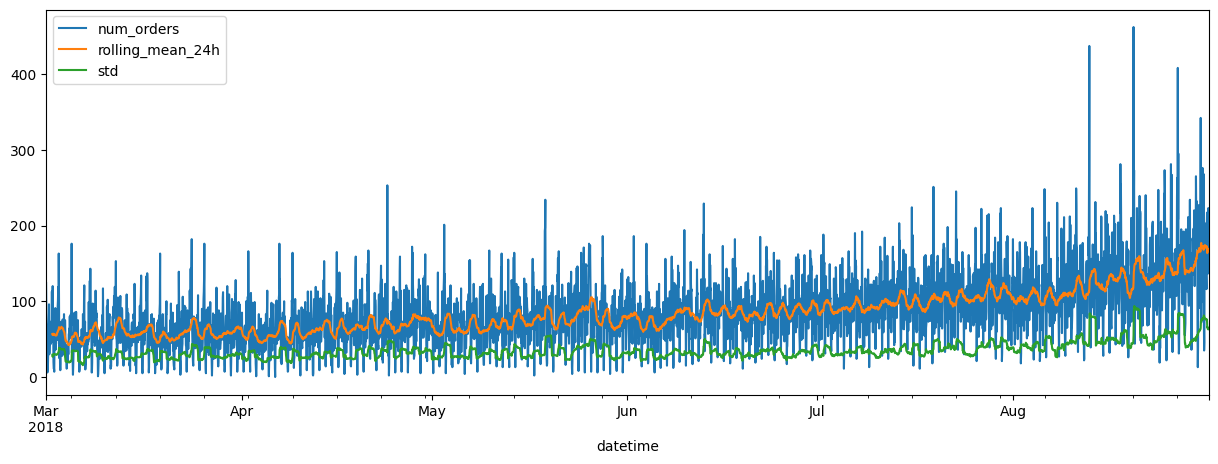

In [33]:
df['rolling_mean_24h'] = df['num_orders'].shift().rolling(24).mean()
df['std'] = df['num_orders'].shift().rolling(24).std()
df.plot(figsize=(15, 5))

Наш график отображает разность временного ряда, скользящее среднее и стандартное отклонение с окном 24 часа:


* Синий график показывает разность значений временного ряда (разности между текущим и предыдущим значением). Видны периоды значительных всплесков и падений, что указывает на резкие изменения заказов.


* Оранжевый график отображает сглаживание ряда с помощью 24-часового окна. Скользящее среднее остаётся около нуля, что ожидаемо для данных, преобразованных через разность.


* Зелёный график показывает изменчивость временного ряда в 24-часовом окне. Чем больше стандартное отклонение, тем сильнее вариативность данных. На графике стандартное отклонение стабильно невысокое, но оно увеличивается в периоды резких всплесков.



In [34]:
df.drop(['rolling_mean_24h', 'std'], axis=1, inplace=True)

## Обучение

Подготовим выборки для обучения моделей. Размер тестовой выборки 10% от исходных данных.

In [35]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Данные разбиты корректно: обучающая выборка заканчивается 13 августа в 13:00 , а тестовая начинается 13 августа 14:00.

### Качество прогноза

Измерим качество предсказания временных рядов и проверим модели на адекватность. Эти модели пригодятся в автоматизации принятия технических решений.

Спрогнозируем временные двумя способами:

Первый способ — прогнозом константой. Количество заказов предскажем медианой, сохраним значения в переменной pred_median и найдем для этого прогноза значение RMSE. 

In [36]:
median_train = train['num_orders'].median()

pred_median = np.full(test.shape[0], median_train)

mse = mean_squared_error(test['num_orders'], pred_median)
rmse = sqrt(mse)

print(f"RMSE {rmse}")

RMSE 87.15277582981295


Второй способ — предыдущим значением ряда. Предскажем количество заказов и найдем для этого прогноза значение RMSE.

In [38]:
pred_previous = test['num_orders'].shift()

pred_previous.iloc[0] = train['num_orders'].iloc[-1]

mse = mean_squared_error(test['num_orders'], pred_previous)
rmse = sqrt(mse)

print(f"RMSE на тестовой выборке: {rmse}")

RMSE на тестовой выборке: 58.856486242815066


Прогноз предыдущим значением показывает лучшее качество (RMSE ниже), но не использует дополнительных признаков, которые могли бы улучшить точность.

### Создание признаков

Создадим признаки для горизонта прогнозирования в один шаг.

Напишем функцию для создания признаков

In [39]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data



df_features = make_features(df, 24, 24)

В нашей функции мы сначала создаем 3 новых календарных признака: это `month`,  `day`, `dayofweek`.

Затем вычислим отстающие значения. Добавим новые признаки: `lag_1`, `lag_2` и т.д

И добавим Скользящее среднее который задаёт общий тренд временного ряда (`rolling_mean`).

In [40]:
df_features.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_features.shape

(4416, 29)

Удалим пропущенные значения

In [42]:
df_features = df_features.dropna()
df_features.shape

(4392, 29)

### Обучение моделей

Выделем признаки и целевой признак.

In [43]:
X_train = df_features.drop(['num_orders'], axis = 1)
y_train = df_features['num_orders']
X_test = df_features.drop(['num_orders'], axis = 1)
y_test = df_features['num_orders']

### LinearRegression

Обучим линейную регрессию

In [45]:
def rmse_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return sqrt(mean_squared_error(y, y_pred))

model_lr = LinearRegression()

cv_scores = cross_val_score(
    model_lr,
    X_train,
    y_train,
    cv=tscv,
    scoring=rmse_scorer
)
print(f"LinearRegression: Среднее RMSE: {np.mean(cv_scores):.2f}")

LinearRegression: Среднее RMSE: 29.85


### LGBMRegressor

Обучим модель градиентного бустинга `LGBM`

In [46]:
param_grid_lgbm = {
    'n_estimators': [10, 50, 100],
    'max_depth': range(1, 11),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
}

In [47]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

grid_search_lgbm = GridSearchCV(
    model_lgbm, 
    param_grid_lgbm, 
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_lgbm.fit(X_train, y_train)


best_model_lgbm = grid_search_lgbm.best_estimator_
best_score_lgbm = grid_search_lgbm.best_score_
rmse_lgbm = np.sqrt(-best_score_lgbm)

print('GridSearchCV_LGBM - параметры:\n\n', best_model_lgbm)
print('GridSearchCV_LGBM - Метрика лучшей модели на кросс-валидации:', rmse_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5455
[LightGBM] [Info] Number of data points in the train set: 4392, number of used features: 28
[LightGBM] [Info] Start training from score 84.573543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

### RandomForestRegressor

Обучим модель `RandomForest`

In [48]:
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

In [49]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)


grid_search_rf = GridSearchCV(
    model_rf, 
    param_grid_rf, 
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)


grid_search_rf.fit(X_train, y_train)

best_model_rf = grid_search_rf.best_estimator_
best_score_rf = grid_search_rf.best_score_
rmse_rf = np.sqrt(-best_score_rf)

print('GridSearchCV_RF - параметры:\n\n', best_model_rf)
print('GridSearchCV_RF - Метрика лучшей модели на кросс-валидации:', rmse_rf)

GridSearchCV_RF - параметры:

 RandomForestRegressor(min_samples_split=5, random_state=42)
GridSearchCV_RF - Метрика лучшей модели на кросс-валидации: 29.282107560119382


Наилучший результат показала модель **LGBM Regressor**.

### Тест лучшей модели

In [50]:
y_pred = best_model_lgbm.predict(X_test)

lgbm_mse = mean_squared_error(y_test, y_pred)

lgbm_rmse = np.sqrt(lgbm_mse)

print("LightGBM RMSE:", lgbm_rmse)

LightGBM RMSE: 20.199492508522226


На тестовой выборке RMSE составило **20.19**.

## Вывод

В рамках проекта для компании "Чётенькое такси" была выполнена задача прогнозирования количества заказов такси на следующий час. Основная цель состояла в том, чтобы построить модель, обеспечивающую значение метрики RMSE на тестовой выборке не более 48.

1. Данные о заказах были агрегированы и ресемплированы до часового интервала.
2. Созданы дополнительные признаки.
3. Были обучены три модели: Linear Regression, LGBMRegressor, RandomForestRegressor.

Наилучший результат показала модель LGBMRegressor с параметрами:

```
LGBMRegressor(max_depth=4, random_state=42)
```

Метрика RMSE для данной модели на кросс-валидации составила 29.04, что является наилучшим результатом среди всех рассмотренных моделей. Для сравнения:
- Linear Regression: Среднее RMSE: 29.85
- RandomForestRegressor: Среднее RMSE: 29.28

Для визуализации результатов построен график временных рядов, отображающий предсказанные значения лучшей модели (LGBMRegressor) и реальные значения из тестовой выборки.

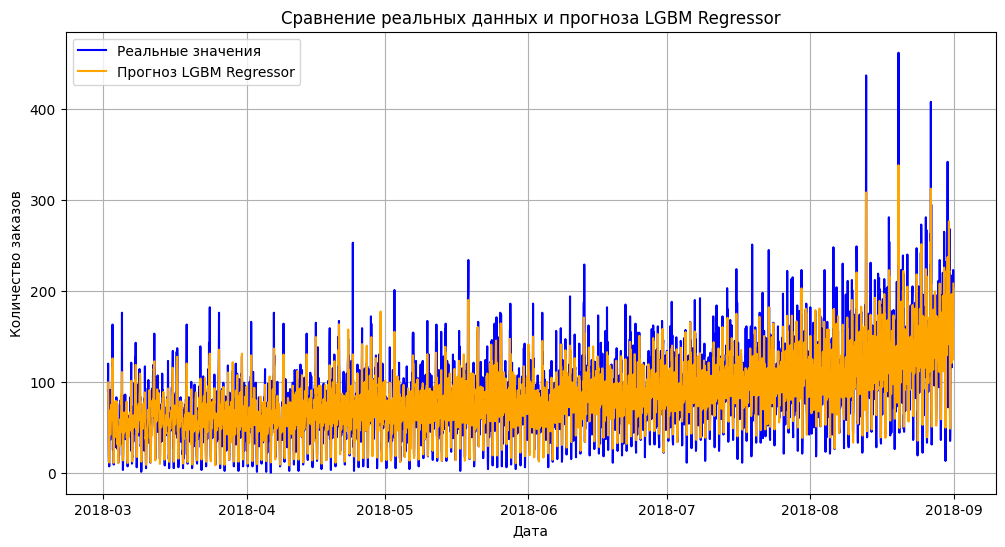

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Реальные значения', color='blue')
plt.plot(y_test.index, y_pred, label='Прогноз LGBM Regressor', color='orange')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Сравнение реальных данных и прогноза LGBM Regressor')
plt.legend()
plt.grid()
plt.show()